In [1]:
import pandas as pd
import pandahouse as ph
import swifter
import hashlib
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250420',
'user':'student',
'password':'dpo_python_2020'
}


query = '''
SELECT distinct user_id, 
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2025-03-21' and toDate(time) <= '2025-03-27'
GROUP BY user_id
'''


df = ph.read_clickhouse(query, connection=connection)

In [2]:
df.head()

,user_id,likes,views,ctr
0,13289,2,32,0.062500
1,121096,12,57,0.210526
2,5090,2,14,0.142857
3,129283,23,80,0.287500
4,4394,25,54,0.462963


In [3]:
def ab_split(user_id, salt='exp_mess_1', n_groups=4):
    test_id = str(user_id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [4]:
df['hash_group'] = df.user_id.swifter.apply(ab_split)

Pandas Apply:   0%|          | 0/41997 [00:00<?, ?it/s]

In [5]:
df.groupby('hash_group', as_index=False).count()

,hash_group,user_id,likes,views,ctr
0,0,10402,10402,10402,10402
1,1,10639,10639,10639,10639
2,2,10575,10575,10575,10575
3,3,10381,10381,10381,10381


In [6]:
df.head()

,user_id,likes,views,ctr,hash_group
0,13289,2,32,0.062500,3
1,121096,12,57,0.210526,1
2,5090,2,14,0.142857,2
3,129283,23,80,0.287500,0
4,4394,25,54,0.462963,3


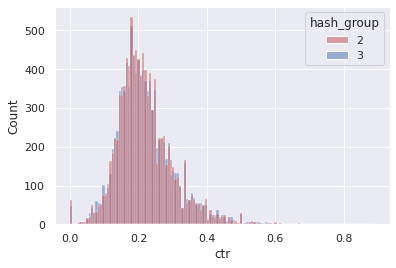

In [7]:
sns.set(rc={'figure.figsize':(16,12)})

groups = sns.histplot(data = df.query("hash_group == 2  or hash_group == 3"), 
              x='ctr', 
              hue='hash_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [8]:
group_2_3 = df.query("hash_group == 2  or hash_group == 3")
group_2_3

,user_id,likes,views,ctr,hash_group
0,13289,2,32,0.062500,3
2,5090,2,14,0.142857,2
4,4394,25,54,0.462963,3
5,129995,1,8,0.125000,3
6,121792,25,126,0.198413,2
...,...,...,...,...,...
41988,106932,2,11,0.181818,3
41990,107388,12,65,0.184615,3
41991,115769,23,104,0.221154,2
41994,124666,32,141,0.226950,3


In [9]:
group2 = group_2_3[group_2_3['hash_group'] == 2]['ctr'].values
group3 = group_2_3[group_2_3['hash_group'] == 3]['ctr'].values

p_values = []

for _ in range(10000):
    # Случайная выборка по 500 значений без повторов
    sample2 = np.random.choice(group2, size=500, replace=False)
    sample3 = np.random.choice(group3, size=500, replace=False)

    # T-test
    result = stats.ttest_ind(sample2, sample3, equal_var=False)
    p_values.append(result.pvalue)

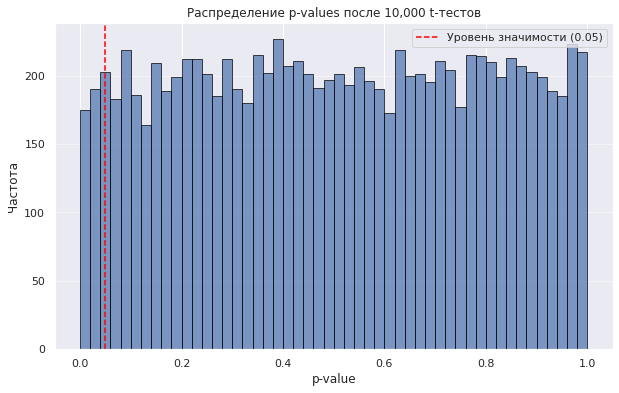

Доля p-values < 0.05: 0.0459


In [10]:
plt.figure(figsize=(10, 6))
plt.hist(p_values, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0.05, color='red', linestyle='dashed', label='Уровень значимости (0.05)')
plt.title('Распределение p-values после 10,000 t-тестов')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# Доля значимых результатов
significance_level = 0.05
significant_count = np.mean(np.array(p_values) < significance_level)
print(f'Доля p-values < {significance_level}: {significant_count:.4f}')

In [13]:
print(stats.ttest_ind(group_2_3[group_2_3.hash_group == 2].ctr,
                group_2_3[group_2_3.hash_group == 3].ctr,
                equal_var=False))
print('Отличие не прокрасилось')
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= group_2_3[group_2_3.hash_group == 2].ctr.sample().values[0] > group_2_3[group_2_3.hash_group == 3].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

Ttest_indResult(statistic=-0.6044833787937078, pvalue=0.5455288661366582)
Отличие не прокрасилось
В 49.47 % случаев A > B. Должно получиться около 50%
